## Лабораторная работа 2

## Модерация изображений

Современные цифровые сервисы позволяют пользователям самостоятельно загружать изображения купленных товаров, документов и т.п. При этом качество загружаемых изображений может оказывать критическое влияние на протекание последующих бизнес-процессов. Примеры:

- Если отзыв покупателя содержит некачественное изображение товара, то такой контент может не представлять интереса для других пользователей.
- Скан документа ненадлежащего качества не позволяет оказать государственную услугу.

В связи с этим представляет проблема автоматической модерации контента. Распространённой задачей в модерации изображений является задача выявления на изображении размытия (Blur Detection).

Эта задача может решаться как пространственными, так и частотными методами.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Задание 1. Детекция размытия пространственными методами

Как мы уже выяснили, оператор Лапласа позволяет выделить границы на изображении. Это достигается за счёт того, что оператор Лапласа выделяет области изображения с высокой интенсивностью изменений. Поэтому если изображение не содержит размытия или эффект размытия незначителен, то результат применения оператора Лапласа к изображению должен обладать большей дисперсией. В свою очередь, если изображение сильно размыто, т.е. границы с трудов восстанавливаются, то лапласиан изображения должен обладать меньшей дисперсией. На этих идеях и основан метод детекции размытия с помощью оператора Лапласа: если дисперсия от лапласиана изображения меньше определённого значения порога, то изображение является размытым, в противном случае — неразмытым.

[Здесь](https://drive.google.com/drive/folders/1r3sOF1ZN4avc-jr5YEAlQ1jCtIxgBMDl?usp=sharing) расположен датасет для выполнения лабораторной работы (основанный на датасете [Blur Dataset](https://www.kaggle.com/datasets/kwentar/blur-dataset)):

- файл `blur-dataset.zip` содержит изображения датасета;
- `train.csv`, `valid.csv`, `test.csv` — таблицы для обучения, валидации и тестирования, имеющие следующую структуру:
  - `filename` — путь к изображению;
  - `blurred` — метка о размытии (1 — размыто, 0 — неразмыто).

На каждое изображение в датасете приходится два изображение с размытием (первое получено с помощью потери фокуса, а второе — движением камеры). Возможно это вам пригодится.

Поскольку датасет достаточно большой, то лучше выполнять лабораторную работу в Colab, что и будем предполагать в дальнейшем.

Установим утилиту `gdown`, позволяющую подгрузить расшаренные в Google Drive файлы, и загрузим их.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -qq /content/gdrive/MyDrive/blur-dataset/images.zip -d ./blur-dataset 

In [ ]:
# !pip install gdown
# !gdown --folder https://drive.google.com/drive/folders/1r3sOF1ZN4avc-jr5YEAlQ1jCtIxgBMDl

Посмотрим содержимое датасета:

In [ ]:
# !ls -al .content/blur-dataset

Распакуем архив `images.zip`, содержащий все изображения:

In [ ]:
# !unzip -qq ./blur-dataset/images.zip -d ./blur-dataset

Перечислим основные импорты, которые понадобятся нам в дальнейшем:

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

Подгрузим данные об изображениях, предназначенных для обучения:

In [ ]:
# train_df = pd.read_csv('./blur-dataset/train.csv')
train_df = pd.read_csv('/content/gdrive/MyDrive/blur-dataset/train.csv')

train_df

,filename,blurred
0,blur-dataset/defocused_blurred/121_HONOR-7X_F.jpg,1
1,blur-dataset/sharp/15_HONOR-7C_S.jpg,0
2,blur-dataset/sharp/32_HUAWEI-P-SMART_S.jpg,0
3,blur-dataset/sharp/50_HONOR-8X_S.jpg,0
4,blur-dataset/motion_blurred/163_SAMSUNG-GALAXY...,1
...,...,...
574,blur-dataset/defocused_blurred/276_NIKON-D3400...,1
575,blur-dataset/motion_blurred/203_IPHONE-SE_M.jpg,1
576,blur-dataset/defocused_blurred/146_NIKON-D3400...,1
577,blur-dataset/defocused_blurred/145_NIKON-D3400...,1


Посмотрим на первые два изображения:

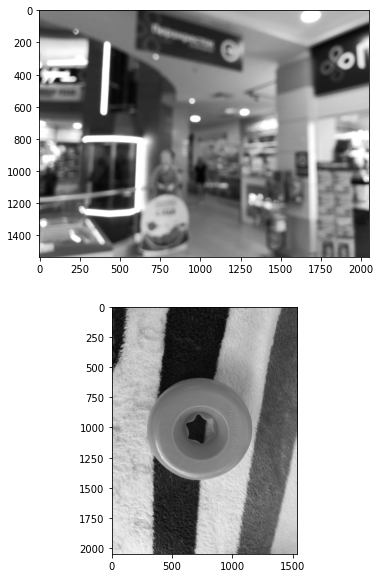

In [ ]:
fig, ax = plt.subplots(2, figsize=(10, 10))

first_image = cv2.imread(train_df.filename[0], 0)
ax[0].imshow(first_image, cmap='gray')

second_image = cv2.imread(train_df.filename[1], 0)
ax[1].imshow(second_image, cmap='gray')

plt.show()

> <font color='red'>Теперь подгрузите таблицы для валидации и тестирования:</font>

In [ ]:
valid_df = pd.read_csv('/content/gdrive/MyDrive/blur-dataset/valid.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/blur-dataset/test.csv')

> <font color='red'>Реализуйте функцию `laplace_var`, вычисляющую вариацию от оператора Лапласа, применённого к изображению, расположенному по пути `filepath`.</font>

In [ ]:
def laplace_var(filepath):
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    r = cv2.Laplacian(image, cv2.CV_64F, ksize=1)
    return np.var(r)

Теперь можно для каждого изображения подсчитать соответствующую дисперсию. Обратите внимание, сколько понадобилось времени на вычисления.

In [ ]:
%%time

train_df['laplace_var'] = train_df['filename'].map(laplace_var)
valid_df['laplace_var'] = valid_df['filename'].map(laplace_var)
test_df['laplace_var'] = test_df['filename'].map(laplace_var)

train_df

CPU times: user 47.5 s, sys: 1.06 s, total: 48.6 s
Wall time: 48.5 s


,filename,blurred,laplace_var
0,blur-dataset/defocused_blurred/121_HONOR-7X_F.jpg,1,58.007202
1,blur-dataset/sharp/15_HONOR-7C_S.jpg,0,39.636198
2,blur-dataset/sharp/32_HUAWEI-P-SMART_S.jpg,0,200.937266
3,blur-dataset/sharp/50_HONOR-8X_S.jpg,0,58.288235
4,blur-dataset/motion_blurred/163_SAMSUNG-GALAXY...,1,31.371753
...,...,...,...
574,blur-dataset/defocused_blurred/276_NIKON-D3400...,1,102.562302
575,blur-dataset/motion_blurred/203_IPHONE-SE_M.jpg,1,103.127540
576,blur-dataset/defocused_blurred/146_NIKON-D3400...,1,27.564291
577,blur-dataset/defocused_blurred/145_NIKON-D3400...,1,22.154662


> <font color='red'>Постройте гистограмму для значений `laplace_var` обучающей таблицы. Сделайте выводы.</font>

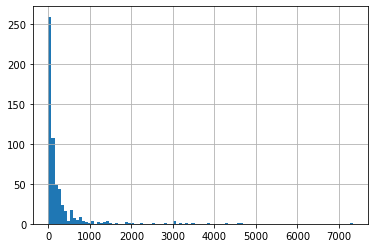

In [ ]:
train_df['laplace_var'].hist(bins=100)

Будем подбирать порог `threshold` для значения `laplace_var` такой, что все изображения, имеющие значение `laplace_var` меньшее `threshold` считаются размытыми, а остальные — неразмытыми.

> <font color='red'>Определите сетку `grid` для перебора значений порога: 250 значений из отрезка $[0, M]$, где $M$ — максимальное значение `laplace_var` в обучающей таблице. Попробуйте функцию `np.linspace`.</font>

In [ ]:
grid = np.linspace(0, train_df['laplace_var'].max(), 250)

> <font color='red'>Реализуйте функцию `accuracy`, вычисляющую точность для заданного датафрейма `df`, порога `threshold` и колонки `column`, содержащей значение для сравнения с порогом. Точность — это среднее значение совпадений истинных меток и предсказанных с помощью порога. Также можно использовать уже импортированную функцию `accuracy_score`.</font>

In [ ]:
def accuracy(df, threshold, column):
    return accuracy_score(df[column] < threshold, df['blurred'])

Здесь в зависимости от порога вычисляются точности для всех наборов данных.

In [ ]:
from functools import partial


laplace_accuracy = partial(accuracy, column='laplace_var')

train_quality = [laplace_accuracy(train_df, v) for v in grid]
valid_quality = [laplace_accuracy(valid_df, v) for v in grid]
test_quality = [laplace_accuracy(test_df, v) for v in grid]

> - <font color='red'>Определите порог, отвечающий максимальной точности на валидационном наборе.
- Выведите точности на всех наборах, отвечающие найденному порогу.</font>

In [ ]:
print(train_quality[np.argmax(valid_quality)], grid[np.argmax(valid_quality)])
print(valid_quality[np.argmax(valid_quality)], grid[np.argmax(valid_quality)])
print(test_quality[np.argmax(valid_quality)], grid[np.argmax(valid_quality)])

0.8272884283246977 206.13119587162038
0.7979274611398963 206.13119587162038
0.8092783505154639 206.13119587162038


> <font color='red'>Постройте зависимость точности на обучающем, валидационном и тестовом наборе от значений сетки. Можно ли найденный ранее порог считать оптимальным?</font>

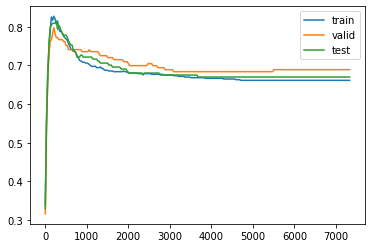

In [ ]:
plt.plot(grid, train_quality, label = "train")
plt.plot(grid, valid_quality, label = "valid")
plt.plot(grid, test_quality, label = "test")
plt.legend()
plt.show()

### Задание 2. Детекция размытия с помощью преобразования Фурье

Всё то же самое надо проделать с помощью преобразования Фурье:

- выберите фильтр высоких частот, который больше всего нравится;
- параметризуйте его через параметр `size`, характеризующий его пространственную геометрию;
- примените фильтр к Фурье-образу изображения;
- восстановите теперь изображение;
- средняя яркость теперь должна быть равна нулю (так как удалили dc component и другие низкие чакстоты), поэтому если среднее значение от получившегося изображения меньше некоторого порога, то исходное изображение было размыто.

Реализуйте функцию `magnitude_mean`, которая возвращает среднее значение трансформированного изображения.

In [ ]:
import math

In [ ]:
def get_filter(shape, size):
    rect = np.zeros(shape)
    rect[
        math.floor(rect.shape[0] * (1/2 - size / 2)): math.floor(rect.shape[0] * (1/2 + size / 2)), 
        math.floor(rect.shape[1] * (1/2 - size / 2)): math.floor(rect.shape[1] * (1/2 + size / 2))
        ] = 1
    return rect

In [ ]:
def apply_filter(image, filter):
    fft = np.fft.fft2(image)
    fftShift = np.fft.fftshift(fft)
    ifftrShift = np.fft.ifftshift(abs(np.ones_like(filter) - filter) * fftShift)
    return abs(np.fft.ifft2(ifftrShift))

In [ ]:
def magnitude_mean(filepath):
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    return np.mean(apply_filter(image, get_filter(image.shape, 0.05)))

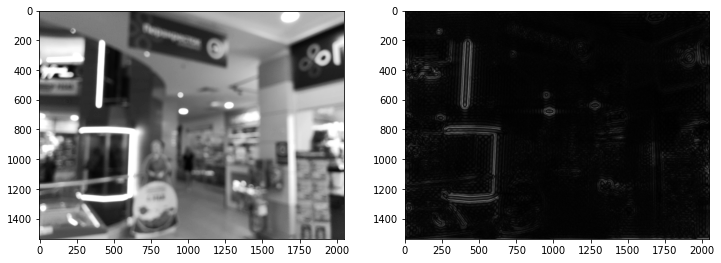

In [ ]:
img = cv2.imread(train_df.filename[0], 0)
img2 = apply_filter(img, get_filter(img.shape, 0.05))
fig, ax = plt.subplots(1, 2, figsize=(12, 10))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(img2, cmap='gray')

In [ ]:
magnitude_mean(train_df.filename[0])

4.752251634780859

> <font color='red'>Теперь, когда функция `magnitude_mean` реализована, выполните все остальные пункты из Задания 1.</font>

In [ ]:
%%time

train_df['magnitude_mean'] = train_df['filename'].map(magnitude_mean)
valid_df['magnitude_mean'] = valid_df['filename'].map(magnitude_mean)
test_df['magnitude_mean'] = test_df['filename'].map(magnitude_mean)

train_df

CPU times: user 6min 20s, sys: 4.95 s, total: 6min 25s
Wall time: 6min 27s


,filename,blurred,laplace_var,magnitude_mean
0,blur-dataset/defocused_blurred/121_HONOR-7X_F.jpg,1,58.007202,4.752252
1,blur-dataset/sharp/15_HONOR-7C_S.jpg,0,39.636198,6.157609
2,blur-dataset/sharp/32_HUAWEI-P-SMART_S.jpg,0,200.937266,7.649833
3,blur-dataset/sharp/50_HONOR-8X_S.jpg,0,58.288235,7.179398
4,blur-dataset/motion_blurred/163_SAMSUNG-GALAXY...,1,31.371753,3.760739
...,...,...,...,...
574,blur-dataset/defocused_blurred/276_NIKON-D3400...,1,102.562302,4.240885
575,blur-dataset/motion_blurred/203_IPHONE-SE_M.jpg,1,103.127540,3.400790
576,blur-dataset/defocused_blurred/146_NIKON-D3400...,1,27.564291,6.313823
577,blur-dataset/defocused_blurred/145_NIKON-D3400...,1,22.154662,3.969302


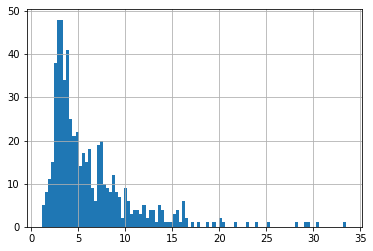

In [ ]:
train_df['magnitude_mean'].hist(bins=100)

> <font color='red'>Наблюдается ли trade-off между детекцией размытия в пространственной и частотной области?</font>

In [ ]:
grid = np.linspace(0, train_df['magnitude_mean'].max(), 250)

In [ ]:
magnitude_accuracy = partial(accuracy, column='magnitude_mean')

train_quality = [magnitude_accuracy(train_df, v) for v in grid]
valid_quality = [magnitude_accuracy(valid_df, v) for v in grid]
test_quality = [magnitude_accuracy(test_df, v) for v in grid]

In [ ]:
print(train_quality[np.argmax(valid_quality)], grid[np.argmax(valid_quality)])
print(valid_quality[np.argmax(valid_quality)], grid[np.argmax(valid_quality)])
print(test_quality[np.argmax(valid_quality)], grid[np.argmax(valid_quality)])

0.8514680483592401 5.788018577854745
0.844559585492228 5.788018577854745
0.8814432989690721 5.788018577854745


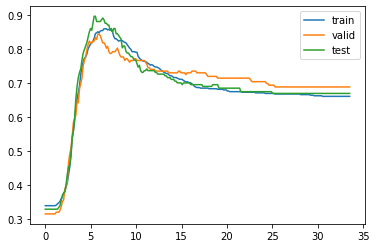

In [ ]:
plt.plot(grid, train_quality, label = "train")
plt.plot(grid, valid_quality, label = "valid")
plt.plot(grid, test_quality, label = "test")
plt.legend()
plt.show()